<a href="https://colab.research.google.com/github/embarced/notebooks/blob/master/deep/intro-rl-2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning with PPO

### high level walk through

1. Understand our use case
1. Idea of Reinforcement Learning with PPO
1. Our first training run
1. leaving out Step IV: Losses and metrics
1. leave out all other details, formulas and link to papers


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 12)
# mpl.rcParams["figure.dpi"] = 300
mpl.__version__

'3.2.2'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# tf-agents should match version of TF
# https://github.com/tensorflow/agents

import sys
if 'google.colab' in sys.modules:
    !pip install -q tf-agents[reverb]==0.7.1 2>/dev/null

    !apt-get update >/dev/null
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start() 
    !pip install -q networkx 2>/dev/null
    !pip install imageio-ffmpeg

     |████████████████████████████████| 1.2 MB 18.1 MB/s 
     |████████████████████████████████| 6.4 MB 32.6 MB/s 
     |████████████████████████████████| 26.9 MB 89.7 MB/s 


In [4]:
import tf_agents
tf_agents.__version__

'0.7.1'

In [5]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [6]:
tf.random.set_seed(42)

In [7]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [8]:
import tensorflow_probability as tfp
tfp.__version__

'0.15.0'

In [9]:
import networkx as nx
nx.__version__

'2.6.3'

# Step I: The application: Guide the bear through feeding time

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/rl/gym.png?raw=1'>

* http://gym.openai.com/
* https://gym.openai.com/docs/
* https://github.com/openai/gym/blob/master/docs/creating_environments.md
* https://github.com/openai/gym/blob/master/gym/core.py

## Our focus is a bit different

* the gym has originally been designed by reinforcement learning researchers as a suite of environments to comapre difference algorithms
* it has a nice API supported by all major reinforcement learning libraries
* since we are practitioners we use that same API to build our own environments

In [10]:
import gym
from gym import spaces
import matplotlib.image as mpi
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from IPython.display import display, clear_output
import numpy as np
import random

# * Each row defines one location in Orso's world
# * S stands for start and is the cave Orso lives in
# * Each location has access to up to 4 other locations defined in each row
# * Each connection is attributed with a value which is the cost of traveling the connection
graph = {
            'S': [('A', 300), ('B', 100), ('C', 200)],
            'A': [('S', 300), ('B', 100), ('E', 100), ('D', 100)],
            'B': [('S', 100), ('A', 100), ('C', 50), ('K', 200)],
            'C': [('S', 200), ('B', 50), ('M', 100), ('L', 200)],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }

def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]

class OrsoEnv(gym.Env):
    metadata = {'render.modes': ['ansi']}

    def __init__(self):
        self.map = graph
        max_paths = 4
        # add more actions here, like, stay at home
        self.action_space = spaces.Discrete(max_paths)
#         self.action_space = spaces.Discrete(max_paths + 1)
#         self.stay_action = max_paths

        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)
        self.reward_range = (-1, 1)
        self.envEpisodeCount = 0
        self.envStepCount = 0
        self._figure = None

        self.reset()
        self.optimum = self.calculate_pots_reward()

        base = "https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/img/rl/graph/"
        self.image_orso = mpi.imread(base + "Orso.png")
        self.image_cave = mpi.imread(base + "Cave.png")
        self.image_honey = mpi.imread(base + "Honey.png")
        self.image_empty_pot = mpi.imread(base + "EmptyPot.png")
        self.nx_graph, self.nx_pos = self._create_nx_graph()

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
            return paths[action]
#         if action == self.stay_action:
#             # just stay where we are, might have a small penalty as the bears slowly starves
# #             return (state, 0)
#             return (state, 100)
        else:
            # sorry, no such action, stay where you are and pay a high penalty
            return (state, 1000)

    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)
        source = self.state

        self.cost = cost
        self.action = action
        self.lastStep_state = self.state
        self.state = destination
        self.potReward = self.pot_reward[destination]
        self.reward = 0
        self.reward = (self.potReward - self.cost) / self.optimum

        self.pot_visited(destination)
        done = (destination == 'S' and self.all_pots_visited())

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += self.reward
        self.stepCount += 1
        self.envStepCount += 1

        if done and not self.isDone:
            self.envEpisodeCount += 1

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": source, "to": destination}
        return observation, self.reward, done, info

    def getObservation(self, position):
        result = np.array([position,
                           self.getPathObservation(position, 0),
                           self.getPathObservation(position, 1),
                           self.getPathObservation(position, 2),
                           self.getPathObservation(position, 3)
                           ],
                          dtype=np.float32)
        all_rest_rewards = list(self.pot_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        paths = self.map[self.state]
        if path < len(paths):
            target, cost = paths[path]
            reward = self.pot_reward[target]
            result = reward - cost
        else:
            result = -1000

        return result

    def pot_visited(self, pot):
        self.pot_reward[pot] = 0

    def all_pots_visited(self):
        return self.calculate_pots_reward() == 0

    def calculate_pots_reward(self):
        sum = 0
        for value in self.pot_reward.values():
            sum += value
        return sum

    # each node gets a reward, either 0 or 1000
    def modulate_reward(self):
        self.pot_reward = {}

        node_names = list(self.map.keys())
        # initialize all nodes with 0
        for node_name in node_names:
            self.pot_reward[node_name] = 0

        # rewards are only at a few random places
        number_of_positions = len(self.map) - 1
        # how many pots shall be full of honey
        number_of_pots = int(number_of_positions / 2)
        self._honeypot_places = []

        # starting from 1, not 0, so that 'S' (position of the cave) never gets a reward 
        samples = random.sample(range(1, number_of_positions + 1), k=number_of_pots)
        for sample in samples:
            # reward for a pot is set here
            self.pot_reward[node_names[sample]] = 1000
            self._honeypot_places = self._honeypot_places + [node_names[sample]]

    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False
        self.state = 'S'
        self.cost = 0
        self.action = 0
        self.lastStep_state = ''
        self.potReward = None
        self._honeypot_places = None
        self.reward = 0
        self.envEpisodeCount += 1
        self.modulate_reward()
        self._figure = None
        return self.getObservation(state_name_to_int(self.state))

    def _create_nx_graph(self):
        """ generates the networkx graph representing orso's world with all its paths.

        :return: graph, positions
        """
        nx_graph = nx.Graph()
        for node_id in self.map.keys():
            zoom = 0.6
            image = self.image_empty_pot
            nx_graph.add_node(node_id, image=image, zoom=zoom)
        for source, connections in self.map.items():
            for action, (target, cost) in enumerate(connections):
                if cost >= 300:
                    color = 'dodgerblue'
                elif cost >= 200:
                    color = 'darkgoldenrod'
                elif cost >= 100:
                    color = 'forestgreen'
                else:
                    color = 'greenyellow'
                directed_label = str(source) + ":" + str(action)
                existing_edge = nx_graph.get_edge_data(source, target)
                if existing_edge is not None: 
                    directed_label = str(existing_edge['label']) + ' - ' + directed_label
                nx_graph.add_edge(source, target, color=color, weight=6, cost=cost, label=directed_label, image=self.image_cave)
        nx_pos = nx.kamada_kawai_layout(nx_graph)
        return nx_graph, nx_pos

    def _render_to_figure(self, render_graph_labels=False, render_costs=False):
        """ Renders the current state as a graph with matplotlib
        """
        # draw graph using matplotlib
        if (self._figure is not None):
            plt.close(self._figure)
        self._figure = plt.figure()
        if len(self._figure.axes) == 0:
            self._figure.add_subplot(1, 1, 1)
        self._figure.axes[0].cla()
        ax = self._figure.axes[0]

        edges = self.nx_graph.edges()
        edge_colors = [self.nx_graph[u][v]['color'] for u, v in edges]
        edge_weights = [self.nx_graph[u][v]['weight'] for u, v in edges]

        nx.draw_networkx(self.nx_graph, pos=self.nx_pos, ax=ax, node_color='lightgrey',
                edgelist=edges, edge_color=edge_colors, width=edge_weights, with_labels=render_graph_labels)

        if render_graph_labels:
          edge_labels = [self.nx_graph[u][v]['label'] for u, v in edges]
          zipped_edge_labels = dict(zip(edges, edge_labels))
          nx.draw_networkx_edge_labels(self.nx_graph, pos=self.nx_pos, ax=ax, edge_labels=zipped_edge_labels)

        if render_costs:
          edge_costs = [self.nx_graph[u][v]['cost'] for u, v in edges]
          zipped_edge_labels = dict(zip(edges, edge_costs))
          nx.draw_networkx_edge_labels(self.nx_graph, pos=self.nx_pos, ax=ax, edge_labels=zipped_edge_labels)

        # draw images on graph nodes
        # set image (according to the current state) and sizes (make orso's current position larger)
        for node_id in self.nx_graph.nodes():
            node = self.nx_graph.nodes[node_id]
            node['zoom'] = 0.4
            if node_id == self.state:
                node['zoom'] = 0.6
            if node_id in self._honeypot_places:
                node['image'] = self.image_empty_pot
                if self.pot_reward[node_id] > 0:
                    node['image'] = self.image_honey
            else:
                node['image'] = None
            if node_id == 'S':
                node['image'] = self.image_cave
            if self.state == node_id:
                node['image'] = self.image_orso

        # position images
        for n in self.nx_pos:
            node = self.nx_graph.nodes[n]
            image = node['image']
            if image is not None: 
                xp, yp = self.nx_pos[n]
                offset_image = OffsetImage(image, node['zoom'])
                offset_image.image.axes = ax
                ab = AnnotationBbox(offset_image, (xp, yp),
                                    xybox=(0, 0),
                                    xycoords='data',
                                    boxcoords="offset points",
                                    pad=0.0,
                                    frameon=False
                                    )
                ax.add_artist(ab)

        self._figure.canvas.draw()

    def _render_ansi(self):
        result = ("Episode: " + ("%4.0f  " % self.envEpisodeCount) +
                  " Step: " + ("%4.0f  " % self.stepCount) +
                  self.lastStep_state + ' --' + str(self.action) + '-> ' + self.state +
                  ' R=' + ("% 2.2f" % self.reward) + ' totalR=' + ("% 3.2f" % self.totalReward) +
                  ' cost=' + ("%4.0f" % self.cost) + ' potR=' + ("%4.0f" % self.potReward) + ' optimum=' + (
                          "%4.0f" % self.optimum)
                  )
        return result

    def _render_rgb(self):
        self._render_to_figure()
        self._figure.canvas.draw()
        buf = self._figure.canvas.tostring_rgb()
        num_cols, num_rows = self._figure.canvas.get_width_height()
        plt.close(self._figure)
        self._figure = None
        result = np.fromstring(buf, dtype=np.uint8).reshape(num_rows, num_cols, 3)
        return result

    def render(self, mode='human', render_graph_labels=False, render_costs=False):
        if mode == 'ansi':
            return self._render_ansi()
        elif mode == 'human':
            clear_output(wait=True)
            self._render_to_figure(render_graph_labels=render_graph_labels, render_costs=render_costs)
            plt.pause(0.01)
            return
        elif mode == 'rgb_array':
            return self._render_rgb()
        else:
            super().render(mode=mode)

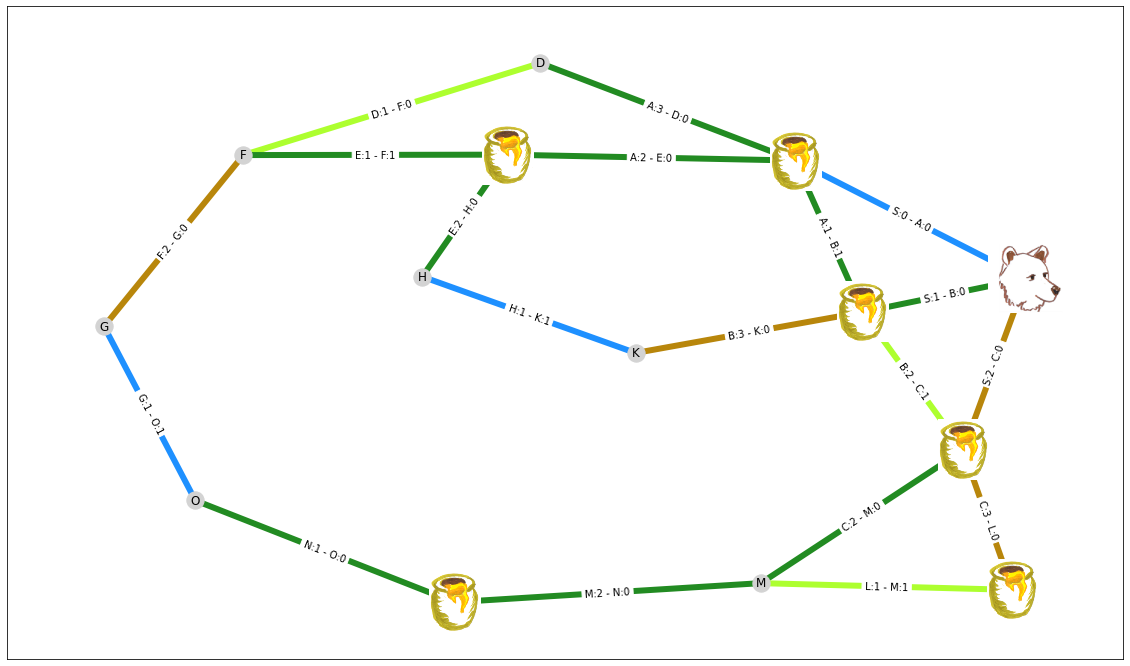

In [11]:
mpl.rcParams['figure.figsize'] = (20, 12)

env = OrsoEnv()
env.render(render_graph_labels=True)

In [12]:
### after each step in a certain directon we get
# 1. the new observation (we will talk about this later)
# 1. the reward for this step/action normalized to 1
# 1. if the game is done (bear needs to collect all honey and return to its cave)
# 1. additional information

observation, reward, done, info = env.step(1)
reward, done, info

(0.15, False, {'from': 'S', 'to': 'B'})

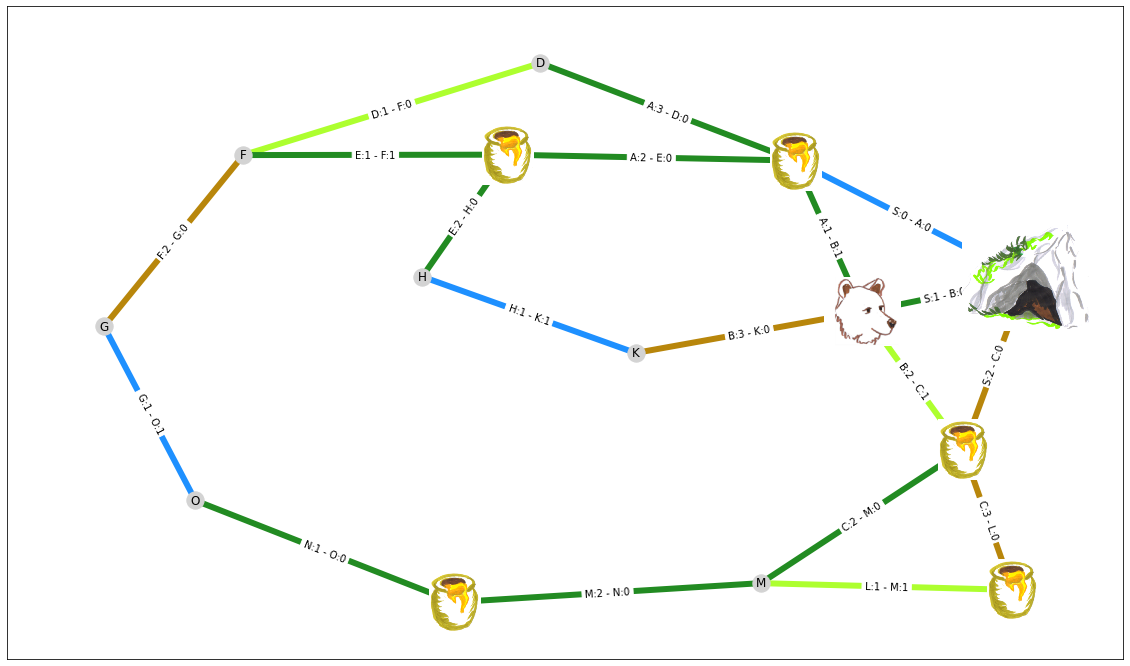

In [13]:
env.render(render_graph_labels=True)

# Step II: Tackling the problem with Reinforcement Learning

## Observation

a flat vector consisting of
1. position of bear
1. 4 combined rewards (cost of travel plus potential honey reward) of the four paths the bear can choose
1. 14 values for each node, 1000 if there still is honey there, 0 otherwise


In [14]:
observation = env.reset()

observation

array([    0.,   700.,  -100.,   800., -1000.,     0.,  1000.,     0.,
        1000.,     0.,     0.,  1000.,  1000.,     0.,     0.,     0.,
        1000.,  1000.,     0.])

In [15]:
observation, reward, done, info = env.step(1)
observation

array([   2., -100.,  900.,  950., -200.,    0., 1000.,    0., 1000.,
          0.,    0., 1000., 1000.,    0.,    0.,    0., 1000., 1000.,
          0.])

In [16]:
reward, done, info

(-0.016666666666666666, False, {'from': 'S', 'to': 'B'})

# Step III: PPO

### PPO (Proximal Policy Optimization)

<img src='https://github.com/embarced/notebooks/raw/master/img/rl/ppo.png'>

<img src='https://github.com/embarced/notebooks/raw/master/img/rl/trajectories.jpg'>



In [17]:
from tf_agents.environments import suite_gym, tf_py_environment

env_name="Orso-v1"

gym.envs.registration.register(id=env_name,entry_point=OrsoEnv, max_episode_steps=25)

# two envs for train and eval
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

# converted to tf-agents tensorflow envs
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)          

In [18]:
train_env.observation_spec()

BoundedTensorSpec(shape=(19,), dtype=tf.float32, name='observation', minimum=array([    0., -1000., -1000., -1000., -1000.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.], dtype=float32), maximum=array([  13., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000.], dtype=float32))

## Value Network


In [19]:
from tf_agents.networks import value_network, actor_distribution_network

value_net = value_network.ValueNetwork(
    train_env.observation_spec(), 
    fc_layer_params=(500, 500, 500),
    # dropout_layer_params=(0.2, 0.2, 0.2)
    )

In [20]:
time_step = train_env.reset()
observation = time_step.observation
value_net(observation)[0].numpy()

array([-15.1616955], dtype=float32)

## Policy Network

In [21]:
# data changes all the time, so risk to overfit is smaller than 
# in pure supervised training, but it might still bring a benefit and does not cost us much:
# https://openai.com/blog/quantifying-generalization-in-reinforcement-learning/
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(500, 500, 500),
    # dropout_layer_params=(0.2, 0.2, 0.2)
    )

In [22]:
# https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical
distribution, _ = actor_net(observation[0], time_step.step_type, ())
distribution.logits.numpy()

array([ -6.5324774, -33.263157 , -10.809059 ,  21.602953 ], dtype=float32)

In [23]:
# greedy, highest category
distribution.mode().numpy()

3

## PPO uses both Networks

In [27]:
#@title Number of Epoches trained in training phase  { run: "auto" }

# 25 by default, but we see better results with more frequent updates of the training data
num_epochs =  10# @param {type:"slider", min:0, max:1000, step:1}


In [28]:
# https://github.com/tensorflow/agents/blob/master/tf_agents/agents/ppo/ppo_agent.py

from tf_agents.agents.ppo import ppo_agent

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) # default is 1e-3

tf_ppo_agent = ppo_agent.PPOAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_net=actor_net,
    value_net=value_net,
    optimizer=optimizer,
    use_gae=False, # just subtract value predictions from empirical return to calculate advantage
#     use_gae=True, 
#     lambda_value= 0.95,
#     discount_factor = 0.99,
    entropy_regularization=0.01, # switched off by default, but we really want to boost initial exploration
    num_epochs=num_epochs)
tf_ppo_agent.initialize()

# Step IV: Configure data collection for phase 2

<img src='https://embarced.github.io/ml-concepts/img/rl2/ppo.png'>

In [24]:
#@title Number of Episodes played in collection phase is how we determine batch sizes  { run: "auto" }

num_episodes =  10# @param {type:"slider", min:0, max:1000, step:1}


In [29]:
# https://www.tensorflow.org/agents/tutorials/5_replay_buffers_tutorial

from tf_agents.metrics import tf_metrics
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.utils import common

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_ppo_agent.collect_data_spec,
    batch_size=1,
    max_length=10001)

avg_return = tf_metrics.AverageReturnMetric()
max_return = tf_metrics.MaxReturnMetric()
min_return = tf_metrics.MinReturnMetric()
avg_length = tf_metrics.AverageEpisodeLengthMetric()
chosen_actions = tf_metrics.ChosenActionHistogram(dtype=tf.int64, )

collect_driver = DynamicEpisodeDriver(train_env,
                                      tf_ppo_agent.collect_policy,
                                      observers=[replay_buffer.add_batch, 
                                                 avg_return, 
                                                 max_return, 
                                                 min_return, 
                                                 avg_length, 
                                                 # FIXME: dtypes int64 crashes on GPU, comment out in that case
                                                 chosen_actions
                                                ],
                                      num_episodes=num_episodes)
# just for optimized execution
tf_ppo_agent.train = common.function(tf_ppo_agent.train)
collect_driver.run = common.function(collect_driver.run)

# Step V: Training Loop

1. collect data by playing
1. train with that data
1. erase all data 
1. repeat for a number of iterations

<img src='https://embarced.github.io/ml-concepts/img/rl2/ppo.png'>

## Challenges

### Don't train for too long
* your sampled data is not perfect
* in the beginning actions taken are random
* if you train for too many iterations you might end up with a bad policy
* a bad policy makes bad experiments
* you might not be able to recover from that

### You want good sample efficiancy
* Playing a game / making an experiment is typically expensive
  * at least more expensive than plain training
* How can you get the best out of your samples?  
* _While it is appealing to perform multiple steps of optimization (...) using the same
trajectory, doing so is not well-justified, and empirically it often leads to destructively large policy
updates_ (https://arxiv.org/abs/1707.06347)

In [32]:
#@title For how long do we want to train { run: "auto" }

num_iterations = 500 # @param {type:"slider", min:0, max:1000, step:1}
log_interval = 25 # @param {type:"slider", min:0, max:100, step:1}

iteration = 4 / step = 50: avg length = 25.0
min return = -1.1250001192092896, max return = -0.34166666865348816, avg return = -0.7616666555404663


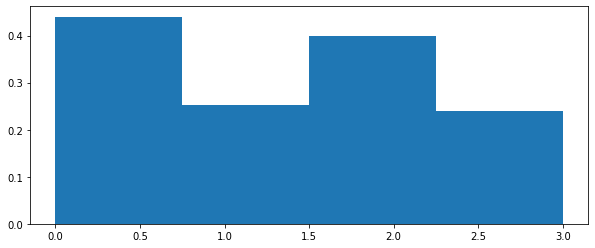

iteration = 9 / step = 100: avg length = 25.0
min return = -0.6166667342185974, max return = 0.333333283662796, avg return = -0.15250001847743988


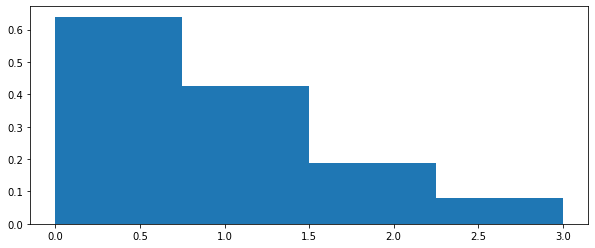

iteration = 14 / step = 150: avg length = 24.799999237060547
min return = -0.2333333045244217, max return = 0.5583333373069763, avg return = 0.05166666582226753


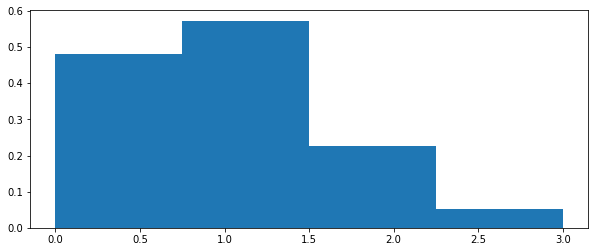

iteration = 19 / step = 200: avg length = 25.0
min return = -0.02499999850988388, max return = 0.3583332598209381, avg return = 0.1783333122730255


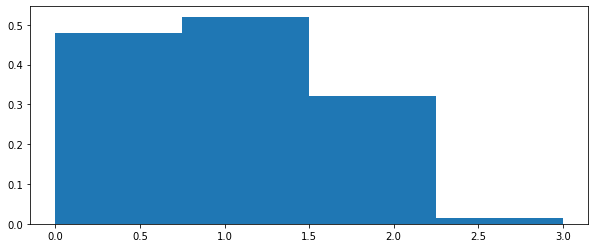

iteration = 24 / step = 250: avg length = 24.799999237060547
min return = -0.03333333879709244, max return = 0.5083333849906921, avg return = 0.2900000214576721


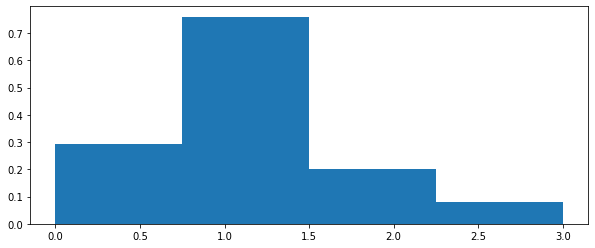

iteration = 29 / step = 300: avg length = 24.600000381469727
min return = -0.2166667878627777, max return = 0.6333333849906921, avg return = 0.2750000059604645


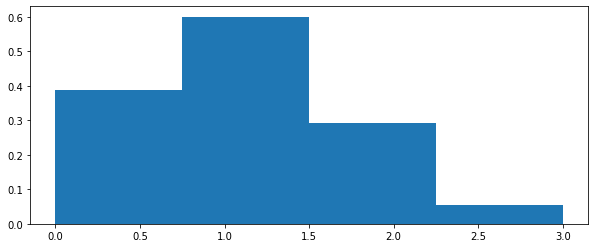

iteration = 34 / step = 350: avg length = 23.799999237060547
min return = 0.14166660606861115, max return = 0.691666841506958, avg return = 0.3516666293144226


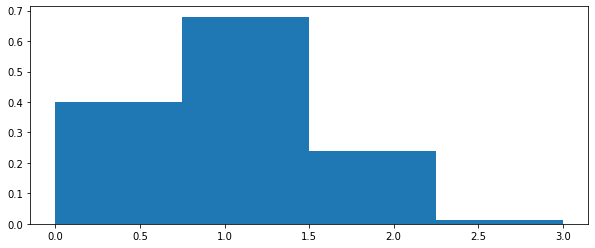

iteration = 39 / step = 400: avg length = 23.799999237060547
min return = -0.016666747629642487, max return = 0.625, avg return = 0.3633333444595337


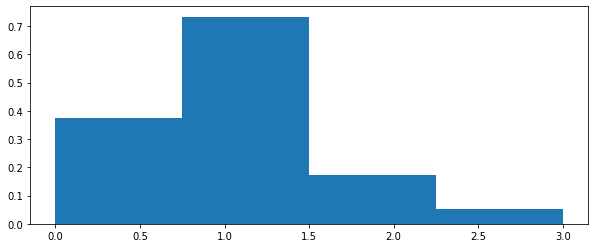

iteration = 44 / step = 450: avg length = 24.5
min return = 0.2666666507720947, max return = 0.6500000953674316, avg return = 0.44583335518836975


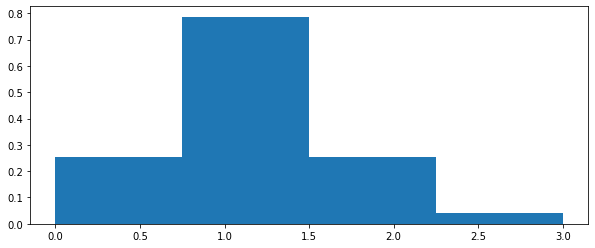

iteration = 49 / step = 500: avg length = 21.899999618530273
min return = 0.4416666030883789, max return = 0.7333333492279053, avg return = 0.5716667771339417


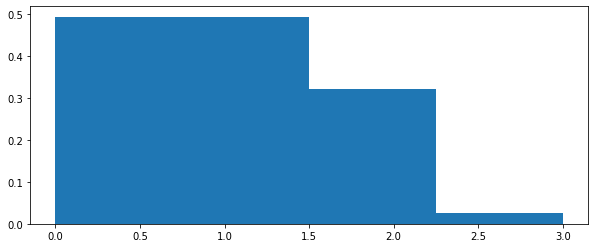

iteration = 54 / step = 550: avg length = 24.399999618530273
min return = 0.09999988228082657, max return = 0.6500002145767212, avg return = 0.429166704416275


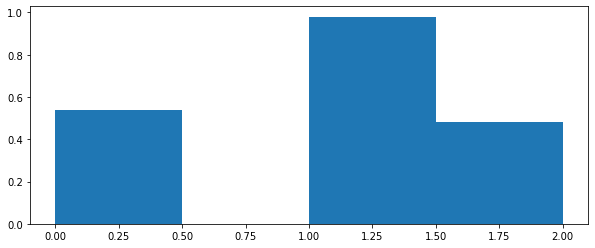

iteration = 59 / step = 600: avg length = 20.899999618530273
min return = 0.2500000298023224, max return = 0.7416667342185974, avg return = 0.5375000238418579


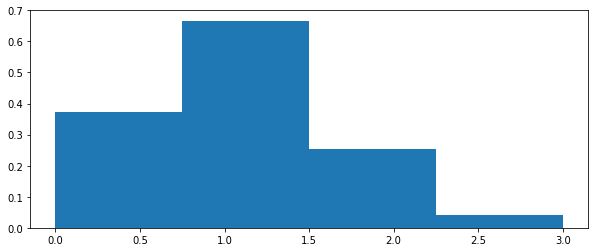

iteration = 64 / step = 650: avg length = 21.299999237060547
min return = -0.058333300054073334, max return = 0.783333420753479, avg return = 0.47833338379859924


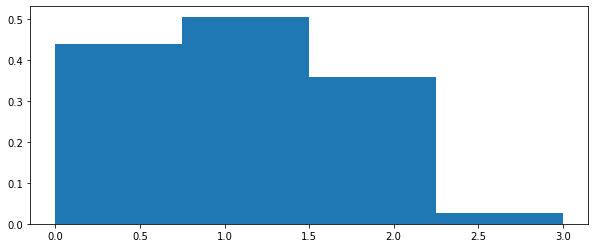

iteration = 69 / step = 700: avg length = 20.100000381469727
min return = 0.34166672825813293, max return = 0.7250000834465027, avg return = 0.5908334255218506


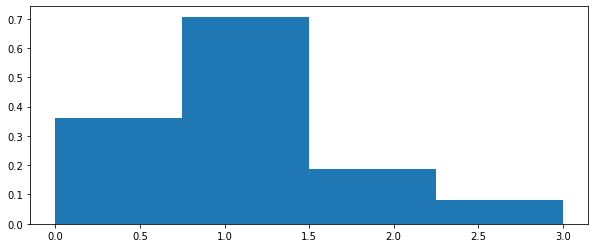

iteration = 74 / step = 750: avg length = 19.0
min return = 0.4416666030883789, max return = 0.800000011920929, avg return = 0.6133333444595337


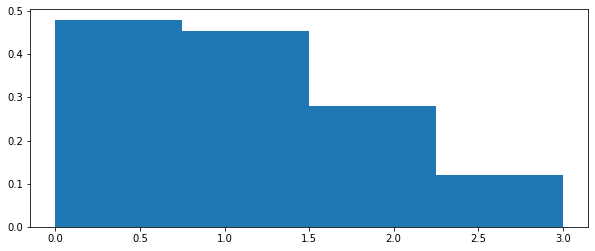

iteration = 79 / step = 800: avg length = 21.200000762939453
min return = 0.19999992847442627, max return = 0.708333432674408, avg return = 0.5333333611488342


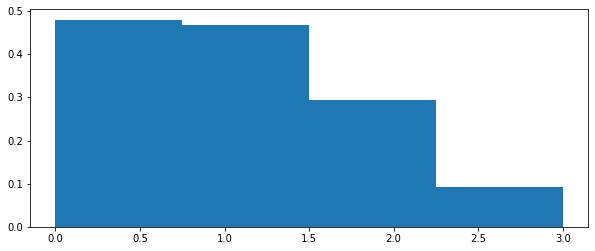

iteration = 84 / step = 850: avg length = 17.799999237060547
min return = 0.5249999761581421, max return = 0.7666667103767395, avg return = 0.661666750907898


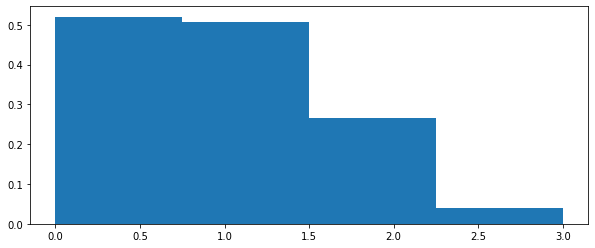

iteration = 89 / step = 900: avg length = 18.299999237060547
min return = 0.4166666567325592, max return = 0.708333432674408, avg return = 0.6250001192092896


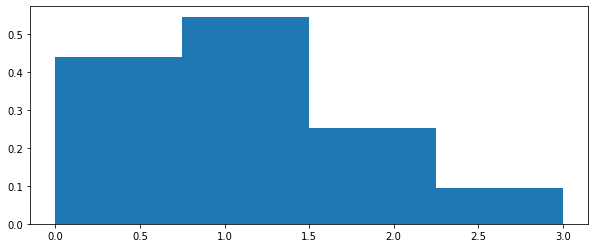

iteration = 94 / step = 950: avg length = 18.600000381469727
min return = 0.40000012516975403, max return = 0.7416666746139526, avg return = 0.6058334112167358


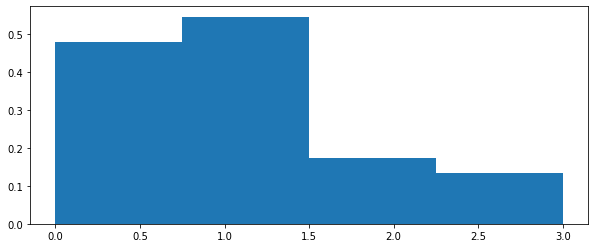

iteration = 99 / step = 1000: avg length = 20.0
min return = 0.3249998390674591, max return = 0.7583333253860474, avg return = 0.6066667437553406


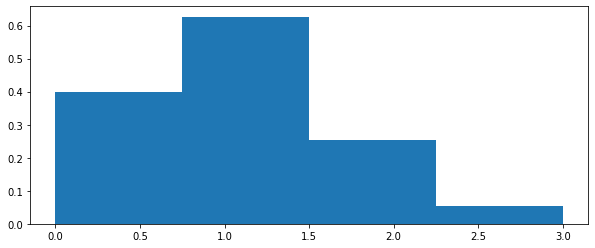

iteration = 104 / step = 1050: avg length = 22.200000762939453
min return = 0.058333367109298706, max return = 0.6583334803581238, avg return = 0.47250014543533325


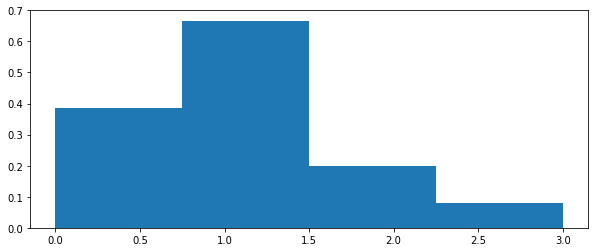

iteration = 109 / step = 1100: avg length = 20.5
min return = 0.2999999225139618, max return = 0.6916667222976685, avg return = 0.5541666746139526


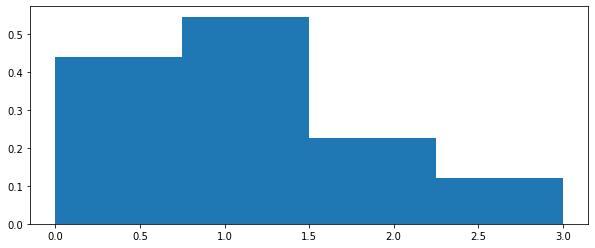

iteration = 114 / step = 1150: avg length = 20.600000381469727
min return = 0.041666675359010696, max return = 0.699999988079071, avg return = 0.5125000476837158


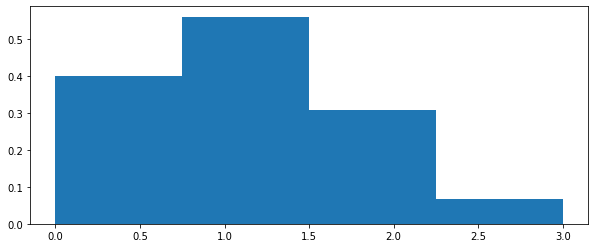

iteration = 119 / step = 1200: avg length = 22.200000762939453
min return = 0.3666667342185974, max return = 0.7500001192092896, avg return = 0.5500000715255737


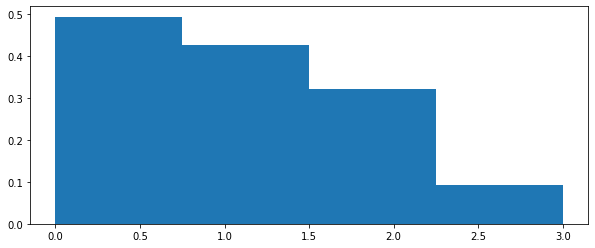

iteration = 124 / step = 1250: avg length = 20.600000381469727
min return = 0.02500009909272194, max return = 0.7333332896232605, avg return = 0.534166693687439


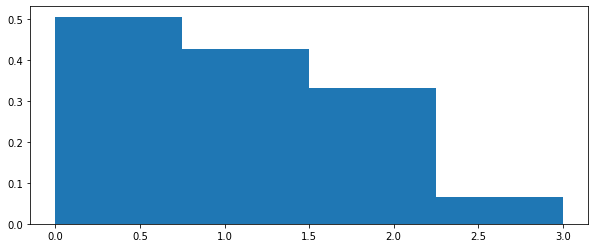

iteration = 129 / step = 1300: avg length = 17.600000381469727
min return = 0.5333333611488342, max return = 0.75, avg return = 0.6408333778381348


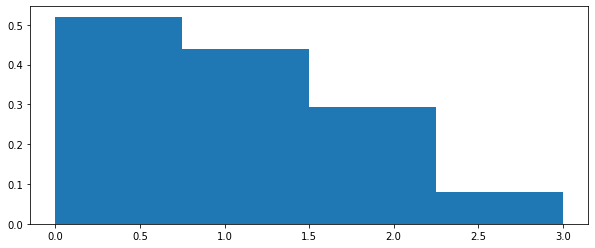

iteration = 134 / step = 1350: avg length = 18.200000762939453
min return = 0.550000011920929, max return = 0.7500000596046448, avg return = 0.6475000977516174


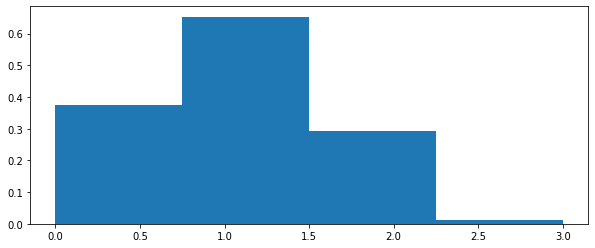

iteration = 139 / step = 1400: avg length = 18.100000381469727
min return = 0.4499998390674591, max return = 0.7583333253860474, avg return = 0.6233333349227905


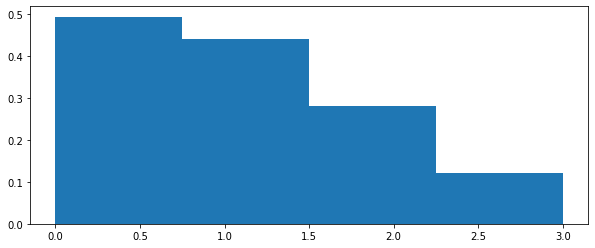

iteration = 144 / step = 1450: avg length = 18.799999237060547
min return = 0.42500007152557373, max return = 0.7833333611488342, avg return = 0.6150000691413879


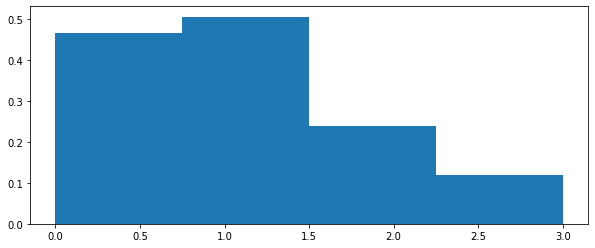

iteration = 149 / step = 1500: avg length = 17.200000762939453
min return = 0.2583332359790802, max return = 0.7333333492279053, avg return = 0.6241666674613953


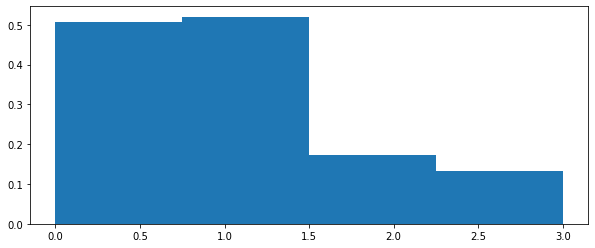

iteration = 154 / step = 1550: avg length = 20.600000381469727
min return = 0.0416666679084301, max return = 0.8499999642372131, avg return = 0.5166667103767395


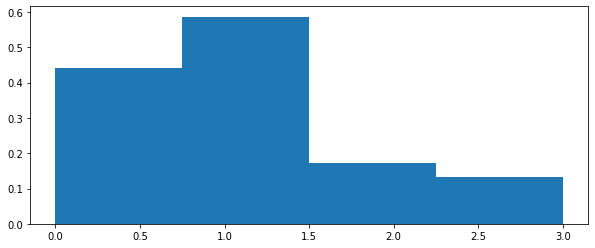

iteration = 159 / step = 1600: avg length = 19.299999237060547
min return = -0.19166666269302368, max return = 0.6916667222976685, avg return = 0.49500003457069397


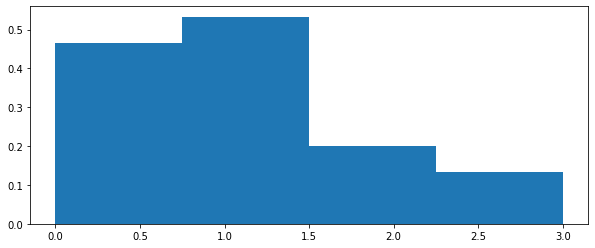

iteration = 164 / step = 1650: avg length = 19.799999237060547
min return = 0.20833328366279602, max return = 0.7750000357627869, avg return = 0.5850000381469727


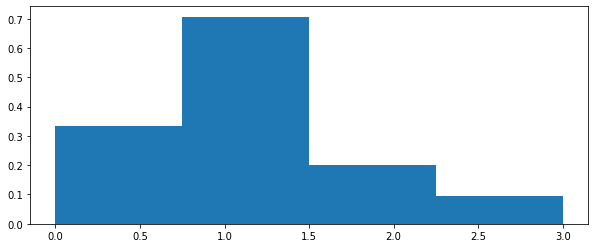

iteration = 169 / step = 1700: avg length = 16.5
min return = 0.5750001668930054, max return = 0.8250000476837158, avg return = 0.6866666674613953


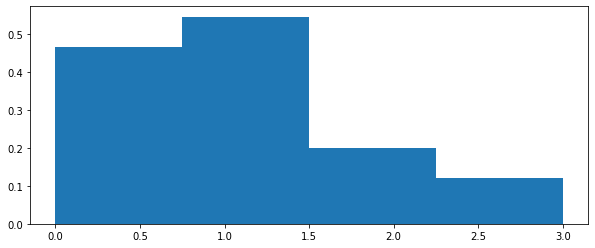

iteration = 174 / step = 1750: avg length = 17.100000381469727
min return = 0.4916667640209198, max return = 0.7750000357627869, avg return = 0.6550000905990601


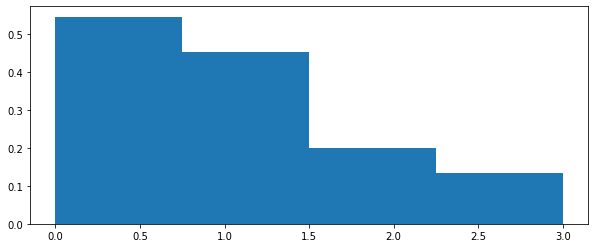

iteration = 179 / step = 1800: avg length = 16.5
min return = 0.5000001192092896, max return = 0.783333420753479, avg return = 0.6658333539962769


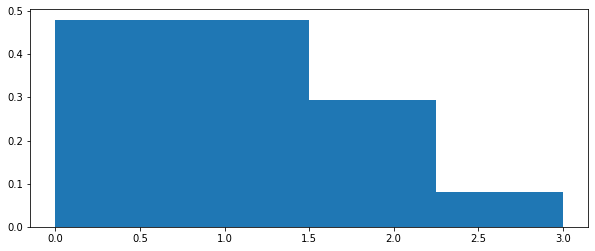

iteration = 184 / step = 1850: avg length = 18.399999618530273
min return = 0.3749999403953552, max return = 0.7916667461395264, avg return = 0.6333333849906921


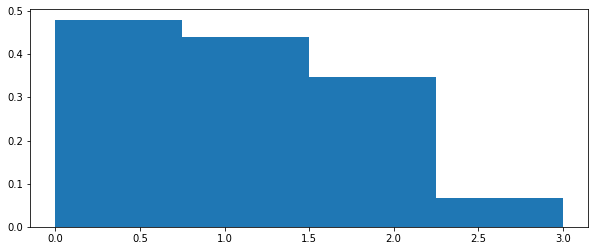

iteration = 189 / step = 1900: avg length = 19.399999618530273
min return = 0.18333317339420319, max return = 0.7083333730697632, avg return = 0.5674999952316284


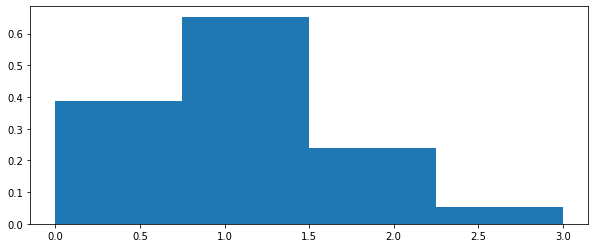

iteration = 194 / step = 1950: avg length = 18.0
min return = 0.5583334565162659, max return = 0.76666659116745, avg return = 0.6658333539962769


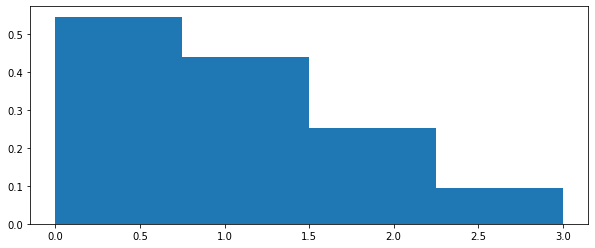

iteration = 199 / step = 2000: avg length = 18.200000762939453
min return = 0.5750000476837158, max return = 0.7416667342185974, avg return = 0.6575000882148743


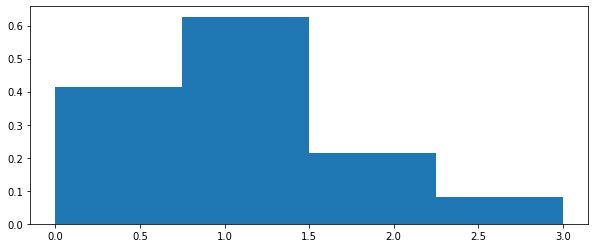

iteration = 204 / step = 2050: avg length = 15.600000381469727
min return = 0.5666666626930237, max return = 0.7666667103767395, avg return = 0.6766667366027832


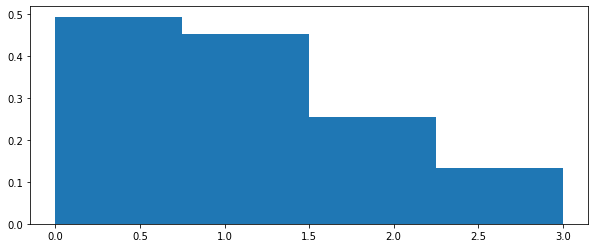

iteration = 209 / step = 2100: avg length = 17.100000381469727
min return = 0.2750000059604645, max return = 0.7916666865348816, avg return = 0.6283333897590637


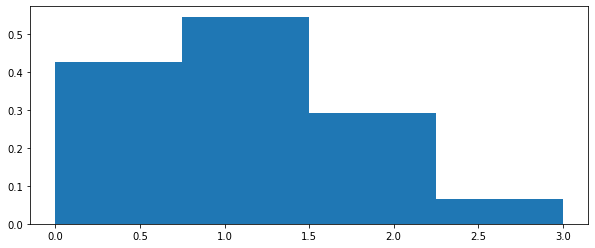

iteration = 214 / step = 2150: avg length = 18.799999237060547
min return = 0.5083333253860474, max return = 0.6916667222976685, avg return = 0.6200000643730164


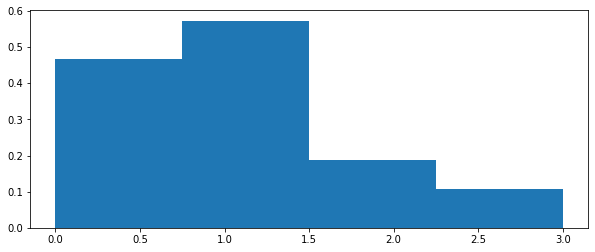

iteration = 219 / step = 2200: avg length = 17.399999618530273
min return = 0.44166675209999084, max return = 0.7500000596046448, avg return = 0.6183333992958069


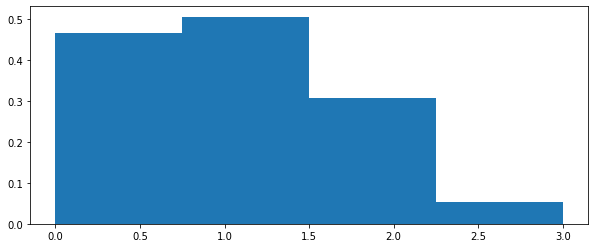

iteration = 224 / step = 2250: avg length = 19.200000762939453
min return = 0.5583333969116211, max return = 0.7916666865348816, avg return = 0.6433333158493042


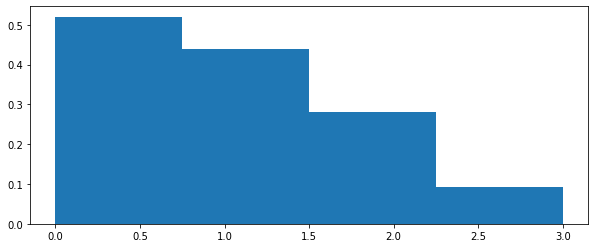

iteration = 229 / step = 2300: avg length = 19.0
min return = 0.3833334743976593, max return = 0.75, avg return = 0.6358334422111511


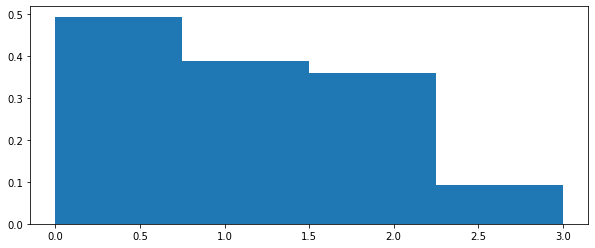

iteration = 234 / step = 2350: avg length = 19.200000762939453
min return = 0.5416666269302368, max return = 0.7250001430511475, avg return = 0.6175000071525574


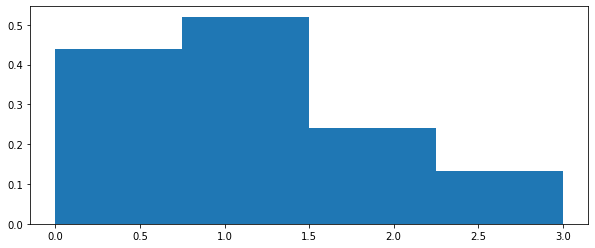

iteration = 239 / step = 2400: avg length = 19.200000762939453
min return = 0.26666682958602905, max return = 0.708333432674408, avg return = 0.596666693687439


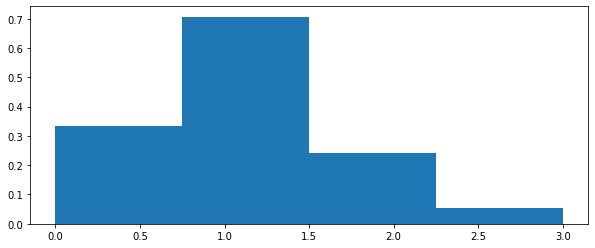

iteration = 244 / step = 2450: avg length = 18.899999618530273
min return = 0.5666667222976685, max return = 0.7916667461395264, avg return = 0.6750000715255737


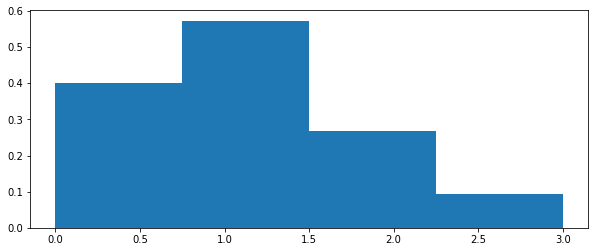

iteration = 249 / step = 2500: avg length = 17.799999237060547
min return = 0.49999991059303284, max return = 0.7166667580604553, avg return = 0.6541668176651001


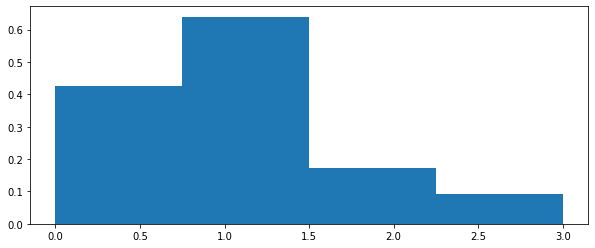

iteration = 254 / step = 2550: avg length = 18.5
min return = 0.29999998211860657, max return = 0.7916666865348816, avg return = 0.5825001001358032


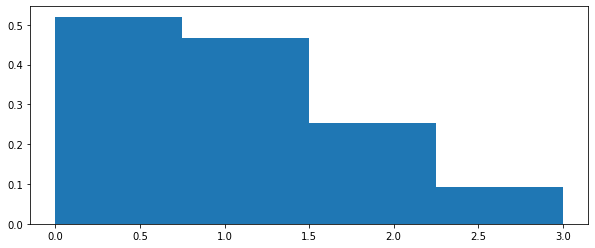

iteration = 259 / step = 2600: avg length = 18.200000762939453
min return = 0.5166667103767395, max return = 0.7500000596046448, avg return = 0.6325001120567322


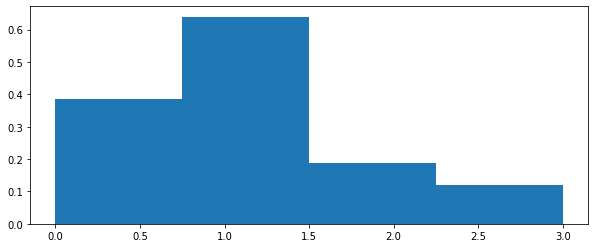

iteration = 264 / step = 2650: avg length = 16.299999237060547
min return = 0.5500001311302185, max return = 0.7833333611488342, avg return = 0.6891666650772095


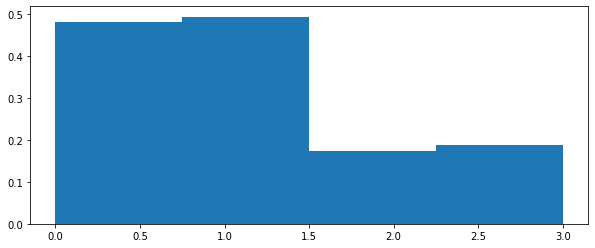

iteration = 269 / step = 2700: avg length = 15.100000381469727
min return = 0.5416668653488159, max return = 0.7583334445953369, avg return = 0.6983333826065063


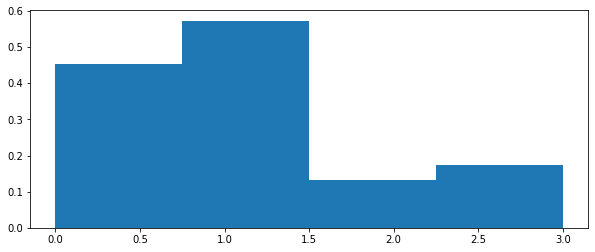

iteration = 274 / step = 2750: avg length = 15.300000190734863
min return = 0.4833335876464844, max return = 0.7916666269302368, avg return = 0.6933333277702332


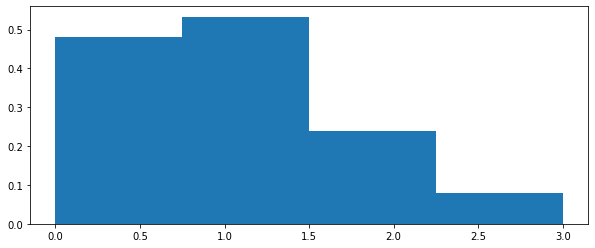

iteration = 279 / step = 2800: avg length = 18.5
min return = 0.5000001192092896, max return = 0.7750000357627869, avg return = 0.6550000309944153


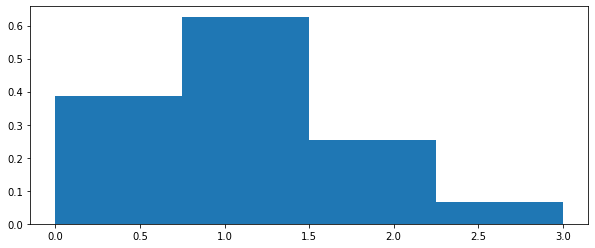

iteration = 284 / step = 2850: avg length = 15.5
min return = 0.6583333611488342, max return = 0.800000011920929, avg return = 0.7108333706855774


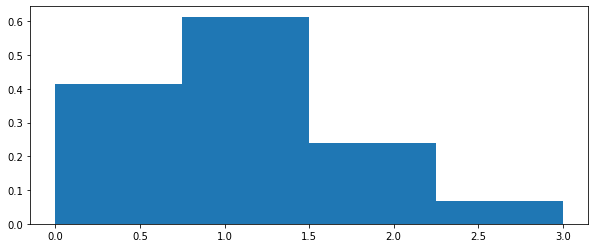

iteration = 289 / step = 2900: avg length = 22.100000381469727
min return = -0.3750000596046448, max return = 0.7083334922790527, avg return = 0.46083346009254456


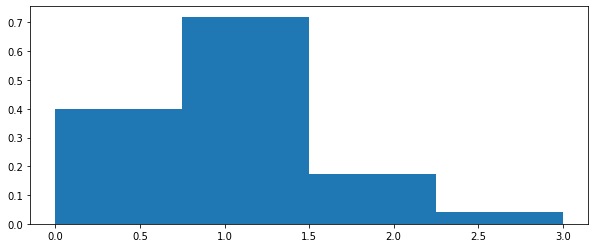

iteration = 294 / step = 2950: avg length = 22.0
min return = -1.033333420753479, max return = 0.7083334922790527, avg return = 0.05749999359250069


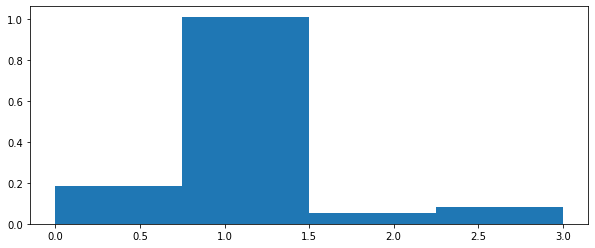

iteration = 299 / step = 3000: avg length = 22.399999618530273
min return = -0.7000000476837158, max return = 0.6750001907348633, avg return = 0.426666796207428


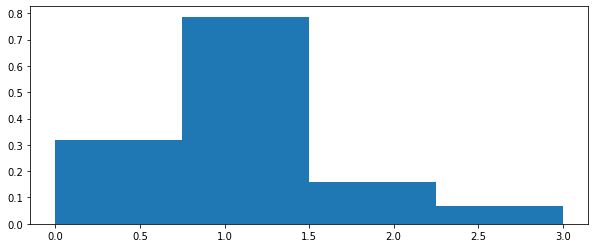

iteration = 304 / step = 3050: avg length = 22.100000381469727
min return = -0.8666667938232422, max return = 0.783333420753479, avg return = 0.2458333969116211


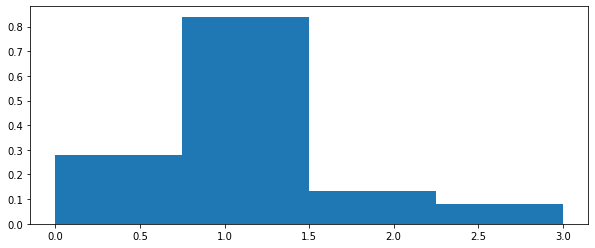

iteration = 309 / step = 3100: avg length = 22.700000762939453
min return = -0.24166670441627502, max return = 0.691666841506958, avg return = 0.5050000548362732


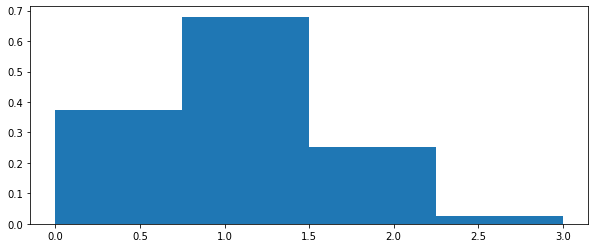

iteration = 314 / step = 3150: avg length = 17.5
min return = 0.24166667461395264, max return = 0.7916667461395264, avg return = 0.6016666889190674


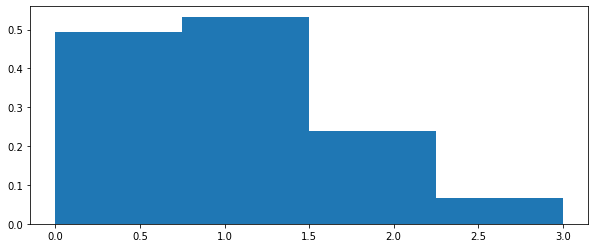

iteration = 319 / step = 3200: avg length = 17.399999618530273
min return = 0.5416666865348816, max return = 0.7416667342185974, avg return = 0.6616666913032532


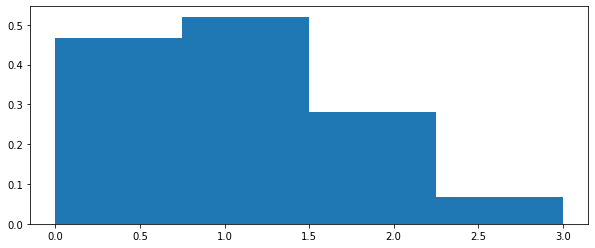

iteration = 324 / step = 3250: avg length = 17.200000762939453
min return = 0.6083332896232605, max return = 0.7250000238418579, avg return = 0.6858333349227905


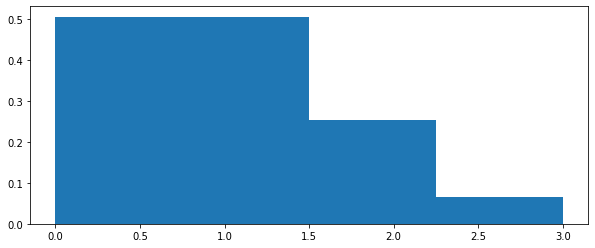

iteration = 329 / step = 3300: avg length = 17.399999618530273
min return = 0.22499991953372955, max return = 0.7666667103767395, avg return = 0.6425000429153442


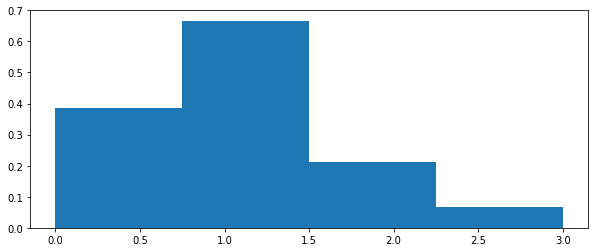

iteration = 334 / step = 3350: avg length = 16.0
min return = 0.5333333611488342, max return = 0.7916667461395264, avg return = 0.6975000500679016


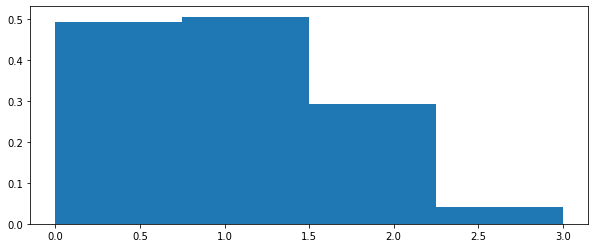

iteration = 339 / step = 3400: avg length = 16.700000762939453
min return = 0.6166666150093079, max return = 0.7666667103767395, avg return = 0.6866666674613953


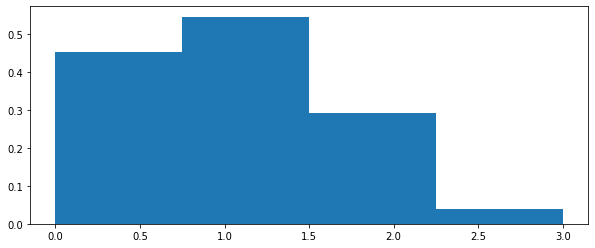

iteration = 344 / step = 3450: avg length = 16.700000762939453
min return = 0.5750002264976501, max return = 0.7583333253860474, avg return = 0.6758334040641785


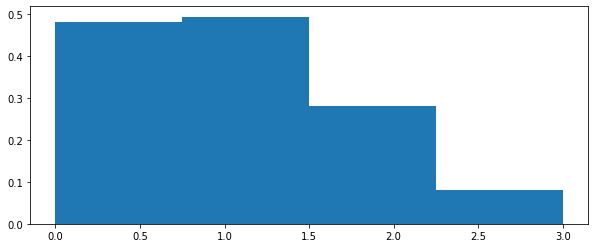

iteration = 349 / step = 3500: avg length = 16.700000762939453
min return = 0.5666667819023132, max return = 0.7750000953674316, avg return = 0.6883333921432495


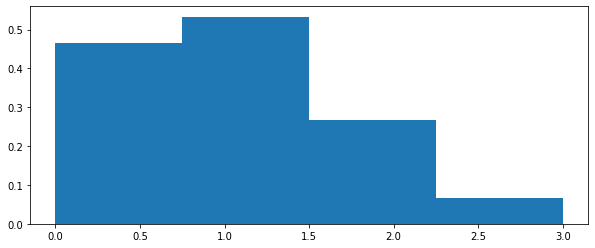

iteration = 354 / step = 3550: avg length = 15.800000190734863
min return = 0.5083333849906921, max return = 0.7750000357627869, avg return = 0.6916667222976685


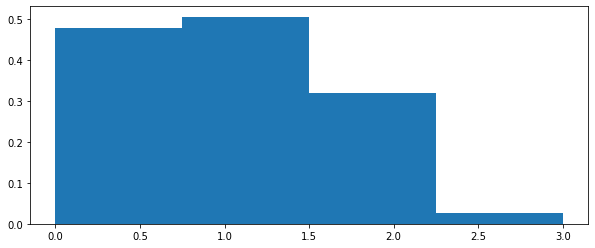

iteration = 359 / step = 3600: avg length = 18.200000762939453
min return = 0.5750001072883606, max return = 0.7166666984558105, avg return = 0.6541666388511658


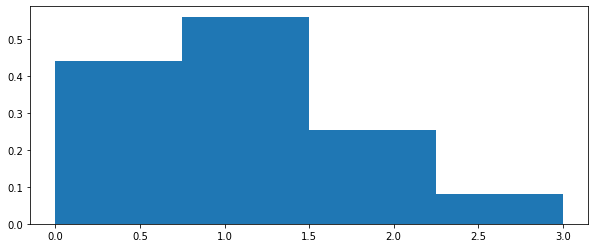

iteration = 364 / step = 3650: avg length = 18.100000381469727
min return = 0.4833334684371948, max return = 0.7750000357627869, avg return = 0.6475000381469727


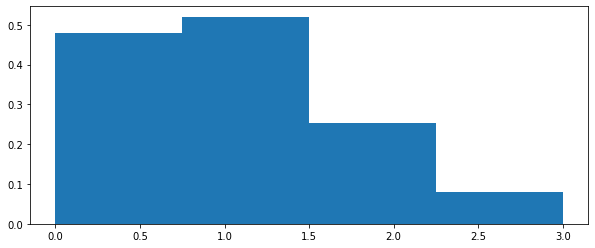

iteration = 369 / step = 3700: avg length = 17.299999237060547
min return = 0.30000004172325134, max return = 0.7583334445953369, avg return = 0.6433333158493042


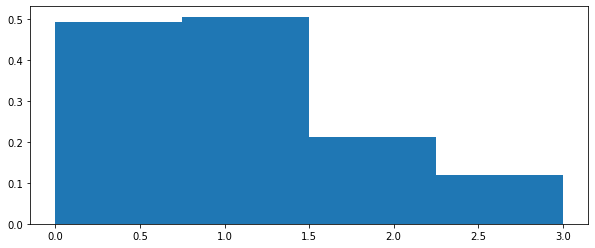

iteration = 374 / step = 3750: avg length = 16.100000381469727
min return = 0.5166667103767395, max return = 0.7166666388511658, avg return = 0.6574999690055847


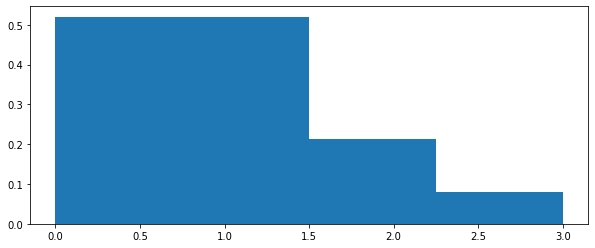

iteration = 379 / step = 3800: avg length = 15.199999809265137
min return = 0.6500000357627869, max return = 0.7500000596046448, avg return = 0.7083333730697632


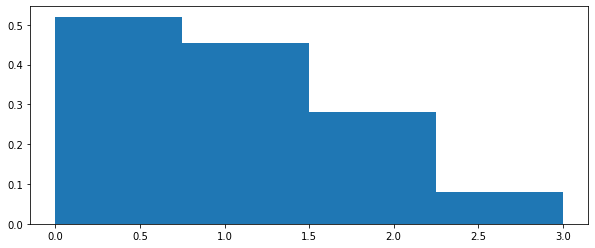

iteration = 384 / step = 3850: avg length = 17.899999618530273
min return = 0.5583333373069763, max return = 0.73333340883255, avg return = 0.6541666984558105


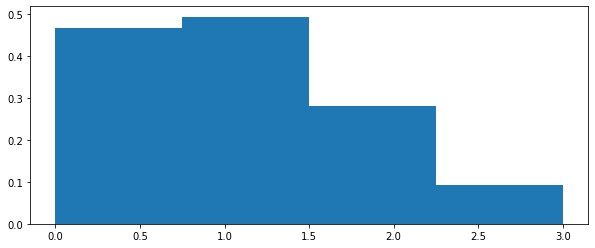

iteration = 389 / step = 3900: avg length = 17.200000762939453
min return = 0.5166666507720947, max return = 0.7666667699813843, avg return = 0.6816667318344116


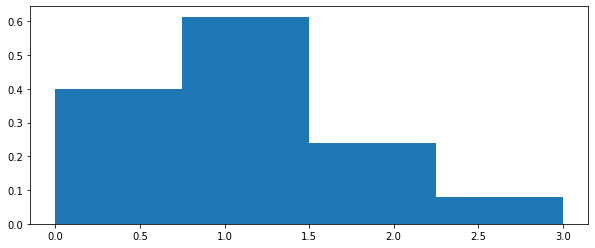

iteration = 394 / step = 3950: avg length = 18.399999618530273
min return = 0.5333332419395447, max return = 0.783333420753479, avg return = 0.6583333015441895


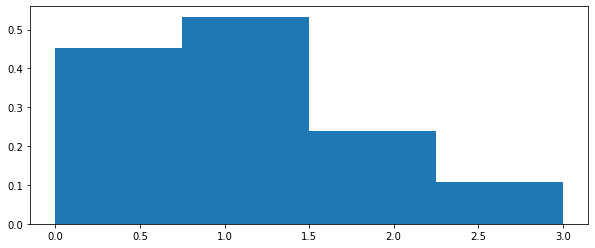

iteration = 399 / step = 4000: avg length = 18.100000381469727
min return = 0.6000000834465027, max return = 0.7583334445953369, avg return = 0.6691666841506958


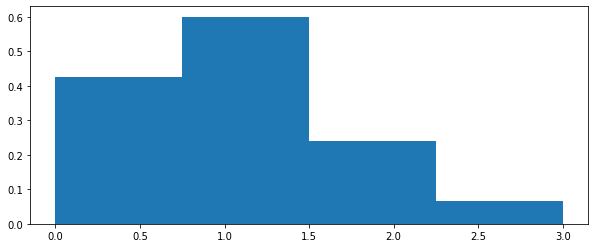

iteration = 404 / step = 4050: avg length = 17.700000762939453
min return = 0.5333333611488342, max return = 0.7666667699813843, avg return = 0.6675001382827759


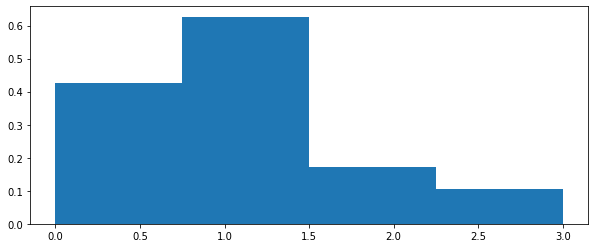

iteration = 409 / step = 4100: avg length = 15.100000381469727
min return = 0.6000000834465027, max return = 0.8083333969116211, avg return = 0.6866666674613953


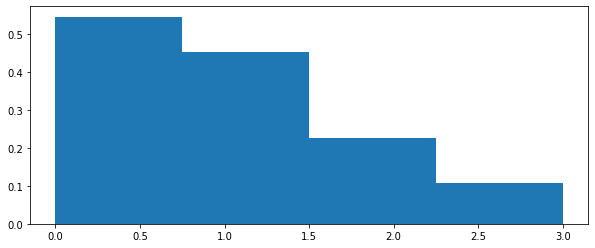

iteration = 414 / step = 4150: avg length = 14.800000190734863
min return = 0.5583333969116211, max return = 0.8083333969116211, avg return = 0.6950000524520874


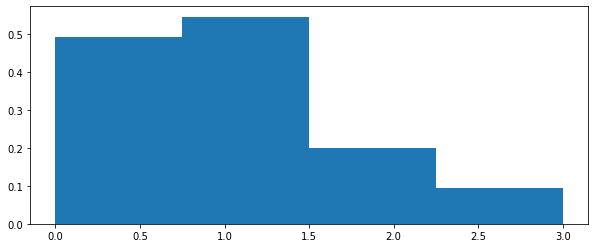

iteration = 419 / step = 4200: avg length = 14.699999809265137
min return = 0.5833332538604736, max return = 0.7666667103767395, avg return = 0.6891666650772095


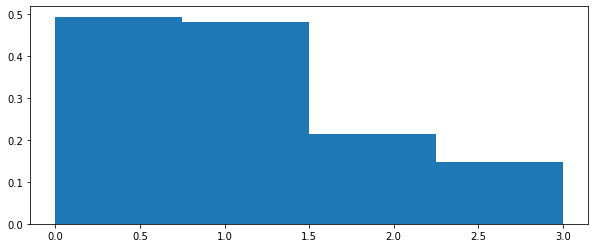

iteration = 424 / step = 4250: avg length = 17.700000762939453
min return = 0.550000011920929, max return = 0.783333420753479, avg return = 0.6458333730697632


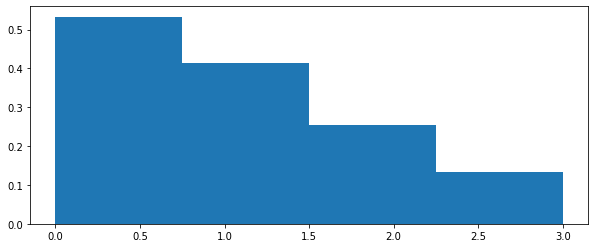

iteration = 429 / step = 4300: avg length = 20.299999237060547
min return = 0.47499990463256836, max return = 0.6833333373069763, avg return = 0.6016667485237122


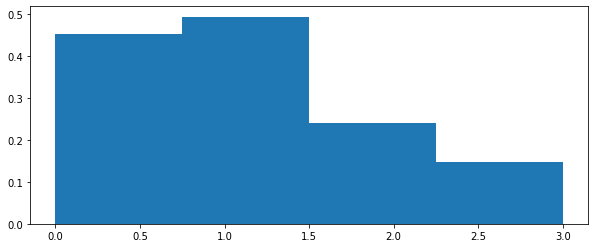

iteration = 434 / step = 4350: avg length = 15.899999618530273
min return = 0.6500000953674316, max return = 0.7500001192092896, avg return = 0.6991667151451111


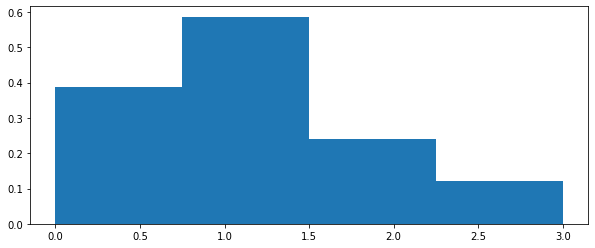

iteration = 439 / step = 4400: avg length = 18.600000381469727
min return = 0.3416666090488434, max return = 0.7666667699813843, avg return = 0.6274999976158142


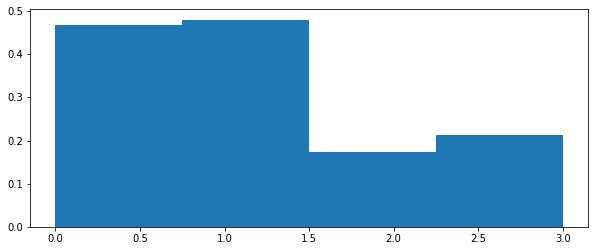

iteration = 444 / step = 4450: avg length = 16.600000381469727
min return = 0.40833351016044617, max return = 0.7583333849906921, avg return = 0.6375001072883606


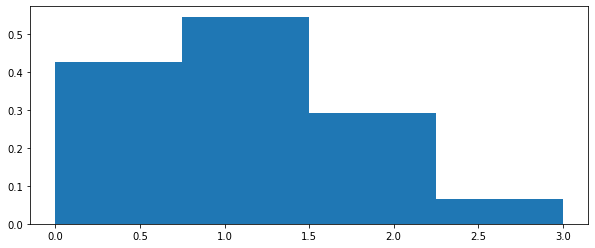

iteration = 449 / step = 4500: avg length = 14.300000190734863
min return = 0.6000000834465027, max return = 0.7666667103767395, avg return = 0.7166666984558105


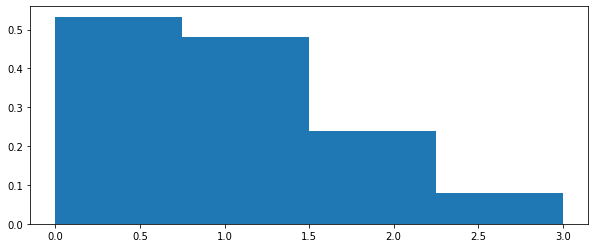

iteration = 454 / step = 4550: avg length = 15.5
min return = 0.6250000596046448, max return = 0.800000011920929, avg return = 0.6800000071525574


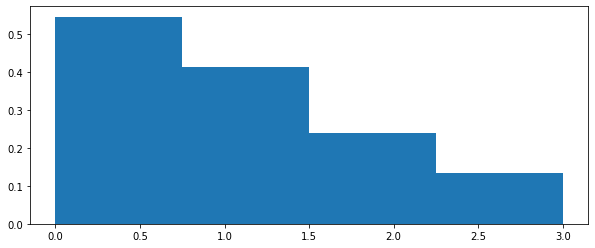

iteration = 459 / step = 4600: avg length = 16.299999237060547
min return = 0.6500000357627869, max return = 0.7750000357627869, avg return = 0.6991667747497559


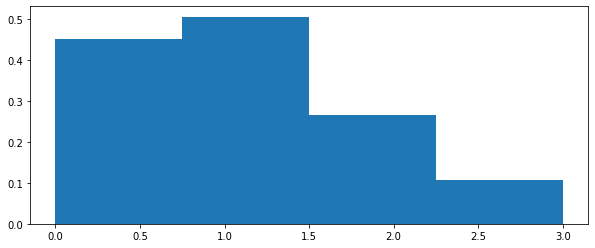

iteration = 464 / step = 4650: avg length = 15.399999618530273
min return = 0.6416668891906738, max return = 0.7916666269302368, avg return = 0.7100000381469727


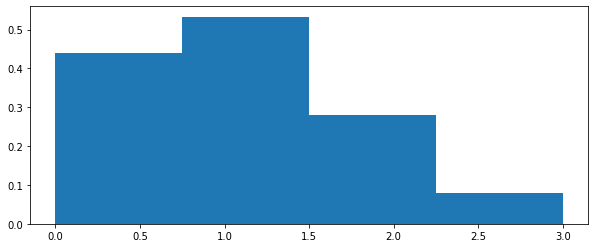

iteration = 469 / step = 4700: avg length = 15.5
min return = 0.28333330154418945, max return = 0.783333420753479, avg return = 0.6750000715255737


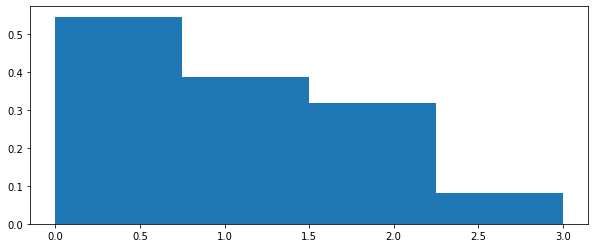

iteration = 474 / step = 4750: avg length = 14.899999618530273
min return = 0.40000009536743164, max return = 0.7666667699813843, avg return = 0.6825000643730164


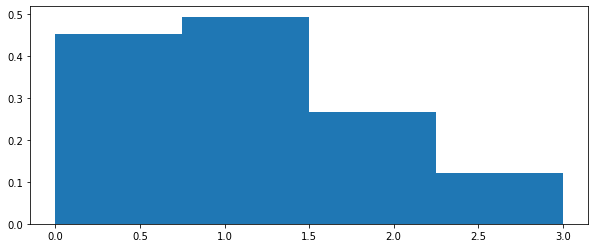

iteration = 479 / step = 4800: avg length = 15.300000190734863
min return = 0.5666669011116028, max return = 0.8000000715255737, avg return = 0.7141666412353516


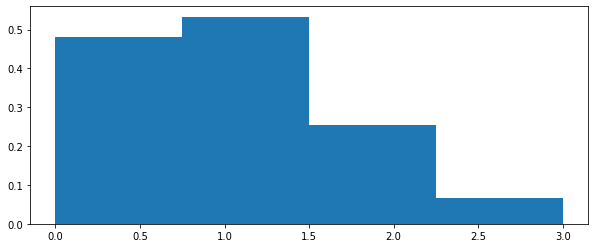

iteration = 484 / step = 4850: avg length = 15.600000381469727
min return = 0.6416667103767395, max return = 0.7250000238418579, avg return = 0.6833333969116211


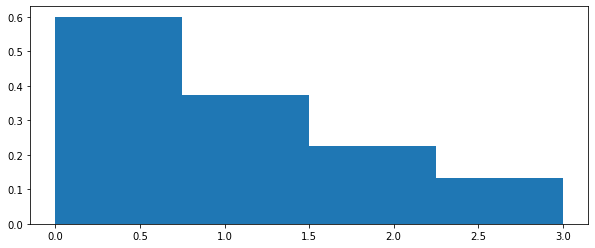

iteration = 489 / step = 4900: avg length = 15.100000381469727
min return = 0.6833334565162659, max return = 0.7833333015441895, avg return = 0.71916663646698


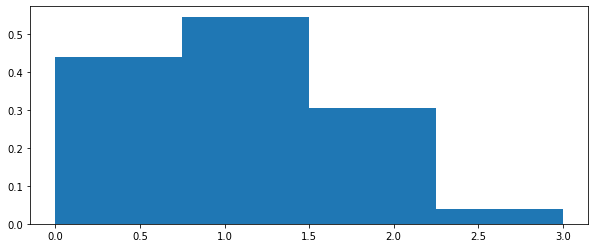

iteration = 494 / step = 4950: avg length = 16.799999237060547
min return = 0.6166667342185974, max return = 0.7666667699813843, avg return = 0.6841667294502258


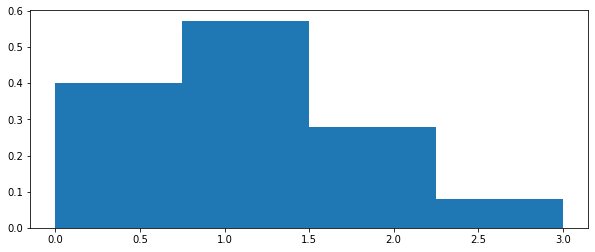

iteration = 499 / step = 5000: avg length = 16.299999237060547
min return = 0.6083332300186157, max return = 0.7666667103767395, avg return = 0.6808333396911621


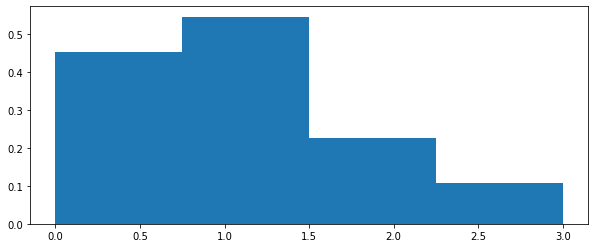

CPU times: user 7min 38s, sys: 18.9 s, total: 7min 57s
Wall time: 5min 8s


In [33]:
%%time

losses = []
policy_gradient_losses = []
value_estimation_losses = []
kl_losses = []
entropy_losses = []

returns = []
lengths = []

for iteration in range(num_iterations):
    
    # 1. collect data by playing
    collect_driver.run()
    # as_dataset would allow choosing a smaller batch instead of full data set
    trajectories = replay_buffer.gather_all()
    
    # 2. train with a new set of trajectories
    loss_info = tf_ppo_agent.train(trajectories)
    # 3. and clear afterwards
    replay_buffer.clear()

    # 4. just tracking of losses and other metrics
    total_loss = loss_info.loss.numpy()
    losses.append(total_loss)

    policy_gradient_loss = loss_info.extra.policy_gradient_loss.numpy()
    policy_gradient_losses.append(policy_gradient_loss)
    
    value_estimation_loss = loss_info.extra.value_estimation_loss.numpy()
    value_estimation_losses.append(value_estimation_loss)

    kl_loss = loss_info.extra.kl_penalty_loss.numpy()
    kl_losses.append(kl_loss)

    entropy_losses.append(loss_info.extra.entropy_regularization_loss.numpy())

    returns.append(avg_return.result().numpy())
    lengths.append(avg_length.result().numpy())    

    # logging
    step = tf_ppo_agent.train_step_counter.numpy()
    if step % log_interval == 0:
        print(f'iteration = {iteration} / step = {step}: avg length = {avg_length.result().numpy()}')
        print(f'min return = {min_return.result().numpy()}, max return = {max_return.result().numpy()}, avg return = {avg_return.result().numpy()}')
        plt.figure(figsize=(10, 4))
        plt.hist(chosen_actions.result(), bins=4, density=True)
        plt.show();

# Step VI: Metrics

In [34]:
mpl.rcParams['figure.figsize'] = (20, 12)
# mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

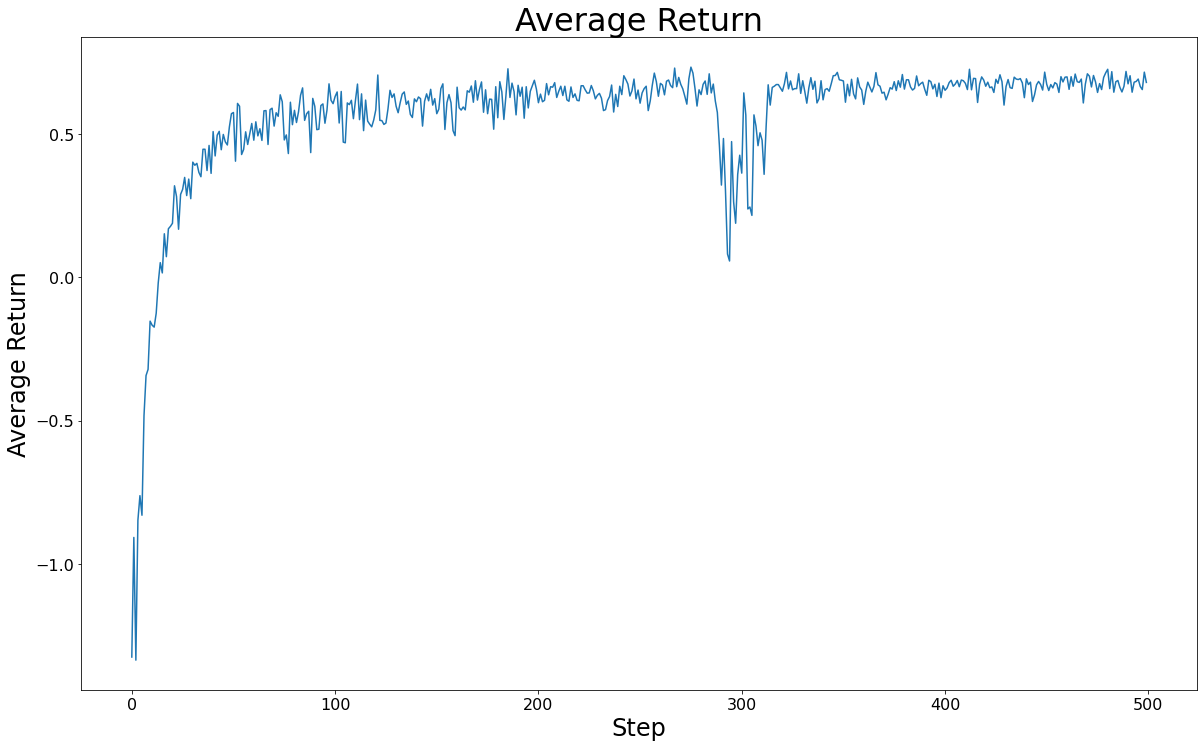

In [35]:
plt.plot(returns)
plt.title('Average Return')
plt.ylabel('Average Return')
plt.xlabel('Step');


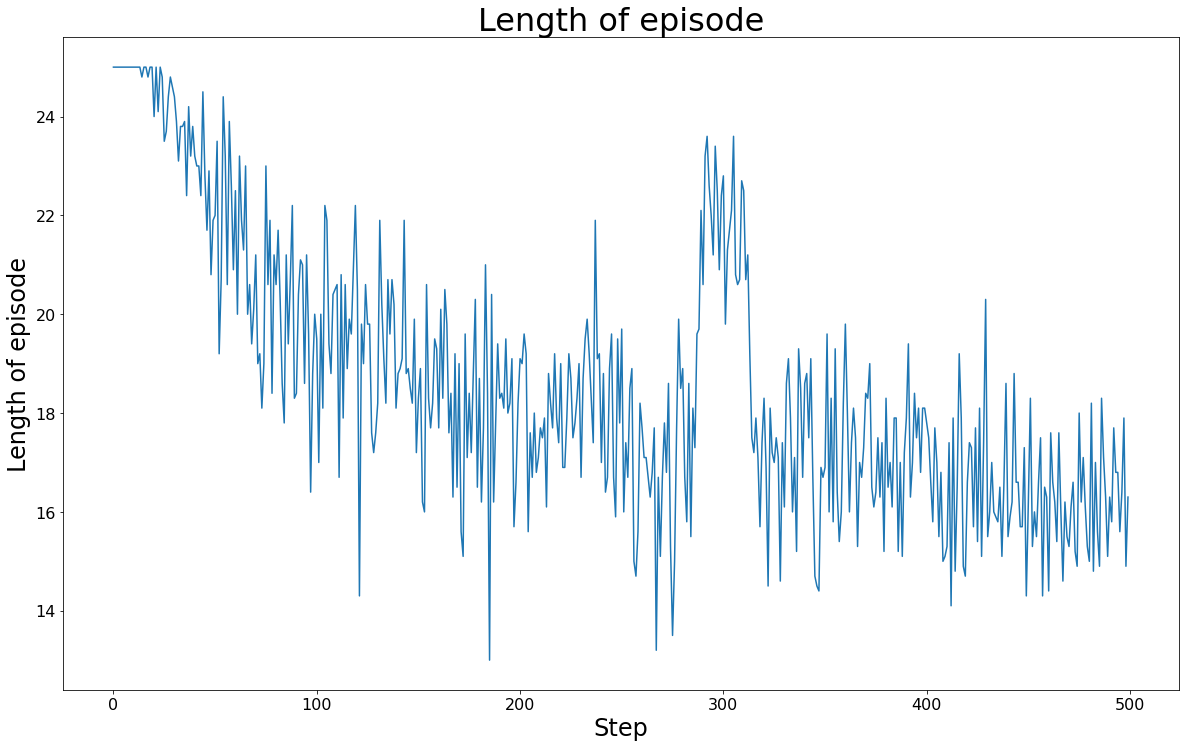

In [36]:
plt.plot(lengths)
plt.title('Length of episode')
plt.ylabel('Length of episode')
plt.xlabel('Step');


# Step VII: In the end all that matters is the policy

<img src='https://github.com/embarced/notebooks/raw/master/img/rl/rl-train-play-2.png'>

In [37]:
tf_ppo_agent.collect_policy

In [38]:
time_step = eval_env.reset()
step = tf_ppo_agent.collect_policy.action(time_step)
logits = step.info['dist_params']['logits']
logits

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[-2.9810972,  5.8173046, -4.127194 , -8.926692 ]], dtype=float32)>

In [39]:
tf_ppo_agent.policy

In [40]:
time_step = eval_env.reset()
tf_ppo_agent.policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

In [41]:
# https://www.tensorflow.org/agents/tutorials/10_checkpointer_policysaver_tutorial

import os
from tf_agents.policies import policy_saver

tf_policy_saver = policy_saver.PolicySaver(tf_ppo_agent.policy)
tf_policy_saver.save('policy')

INFO:tensorflow:Assets written to: policy/assets


INFO:tensorflow:Assets written to: policy/assets


In [42]:
!ls -l policy

total 156
drwxr-xr-x 2 root root   4096 Jan 25 07:18 assets
-rw-r--r-- 1 root root   3364 Jan 25 07:18 policy_specs.pbtxt
-rw-r--r-- 1 root root 143775 Jan 25 07:18 saved_model.pb
drwxr-xr-x 2 root root   4096 Jan 25 07:18 variables


In [43]:
saved_policy = tf.saved_model.load('policy')
saved_policy.signatures

_SignatureMap({'action': <ConcreteFunction signature_wrapper(*, 0/discount, 0/reward, 0/observation, 0/step_type) at 0x7FF31BC94110>, 'get_initial_state': <ConcreteFunction signature_wrapper(*, batch_size) at 0x7FF31C1EEB10>, 'get_train_step': <ConcreteFunction signature_wrapper() at 0x7FF31BF823D0>, 'get_metadata': <ConcreteFunction signature_wrapper() at 0x7FF31EBC1990>})

In [44]:
time_step = eval_env.reset()
action_step = saved_policy.action(time_step)
action_step.action.numpy()[0]

0

In [45]:
time_step = eval_env.reset()
while not time_step.is_last():
  action_step = saved_policy.action(time_step)
  print(action_step.action.numpy()[0])  
  time_step = eval_env.step(action_step.action)

1
3
1
0
1
0
0
1
2
2
2
1
0
0
0
0


In [46]:
import base64
import imageio
import IPython

num_episodes = 1
fps=2

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=fps) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = saved_policy.action(time_step)
#       print(action_step.action.numpy()[0])  
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)